In [41]:
# -*- coding: utf-8 -*-
"""Untitled8.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1WMQ2xtZM2M3BOjClHwKNhui3ZihaSb16
"""

import numpy as np
from tqdm import tqdm
from time import time
from os import getpid
from threading import Thread
from sklearn.manifold import TSNE

class AntCluster:
    def __init__(self, n_ants, n_clusters, data, max_iter=3, alpha=1.0, beta=2.0, rho=0.5):
        self.n_ants = n_ants
        self.n_clusters = n_clusters
        self.data = data
        self.max_iter = max_iter
        self.alpha = alpha
        self.beta = beta
        self.rho = rho
        self.workers = {}
        self.pheromone_matrix = np.ones((len(data), n_clusters))
        self.best_solution = None
        self.best_cost = float('inf')

    def initialize_clusters(self):
        # Randomly initialize clusters for each data point
        return np.random.randint(0, self.n_clusters, len(self.data))

    def calculate_distance(self, point, centroid):
        # Euclidean distance calculation
        return np.linalg.norm(point - centroid)

    def update_pheromone(self, solutions, costs):
        # Pheromone update rule
        delta_pheromone = np.zeros_like(self.pheromone_matrix)
        for i, solution in enumerate(solutions):
            for j, cluster in enumerate(solution):
                delta_pheromone[j, cluster] += 1 / costs[i]

        self.pheromone_matrix = (1 - self.rho) * self.pheromone_matrix + delta_pheromone

    def run(self):
        n_threads = 1
        threads = []
        for t in range(n_threads):
            thread = Thread(target=self.costly_function, args=(self.max_iter//n_threads,))
            threads.append(thread)
            thread.start()
        for t in threads:
            t.join()
        return self.best_solution, self.best_cost
        #return self.costly_function()


    def costly_function(self, n, e=None):
        for iteration in tqdm(range(n)):
            solutions = []
            costs = []
            for ant in range(self.n_ants):
                solution = self.explore()
                cost = self.calculate_cost(solution)
                solutions.append(solution)
                costs.append(cost)
                if cost < self.best_cost:
                    self.best_solution = solution
                    self.best_cost = cost

            self.update_pheromone(solutions, costs)

        return self.best_solution, self.best_cost


    def explore(self):
        # Exploration phase
        clusters = self.initialize_clusters()
        for ant in range(self.n_ants):
            for i, point in enumerate(self.data):
                probabilities = self.calculate_probabilities(i, clusters)
                cluster = np.random.choice(np.arange(self.n_clusters), p=probabilities)
                clusters[i] = cluster
        return clusters

    def calculate_probabilities(self, i, clusters):
        # Calculate probabilities for selecting clusters in the exploration phase
        probabilities = np.zeros(self.n_clusters)
        for j in range(self.n_clusters):
            probabilities[j] = (self.pheromone_matrix[i, j] ** self.alpha) * \
                               ((1 / self.calculate_distance(self.data[i], self.calculate_centroid(i, j, clusters))) ** self.beta)
        probabilities /= np.sum(probabilities)
        return probabilities

    def calculate_centroid(self, i, cluster, clusters):
        # Calculate the centroid of points in the same cluster
        cluster_points = self.data[clusters == cluster]
        if len(cluster_points) == 0:
            return self.data[i]  # If no points in the cluster, return the current point
        return np.mean(cluster_points, axis=0)

    def calculate_cost(self, clusters):
        # Calculate the total cost of the solution
        cost = 0
        for i, point in enumerate(self.data):
            cost += self.calculate_distance(point, self.calculate_centroid(i, clusters[i], clusters))
        return cost

In [23]:
if __name__ == '__main__':
    np.random.seed(42)

    # Create a simple dataset with two clusters
    data_cluster1 = np.random.rand(25, 5) * 2
    data_cluster2 = np.random.rand(25, 5) * 2 + np.array([1, 1, 1, 1, 1])
    data_cluster3 = np.random.rand(25, 5) * 2 + np.array([2, 2, 2, 2, 2])
    data_cluster4 = np.random.rand(25, 5) * 2 + np.array([3, 3, 3, 3, 3])
    data = np.vstack([data_cluster1, data_cluster2, data_cluster3, data_cluster4])
    print(data.shape)

(100, 5)


In [130]:
    data.dtype

dtype('float64')

In [58]:
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    tsne_results = tsne.fit_transform(data)
    tsne_results.shape

[t-SNE] Computing 99 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.001s...
[t-SNE] Computed neighbors for 100 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 1.700560
[t-SNE] KL divergence after 250 iterations with early exaggeration: 46.654339
[t-SNE] KL divergence after 300 iterations: 0.122160


(100, 2)

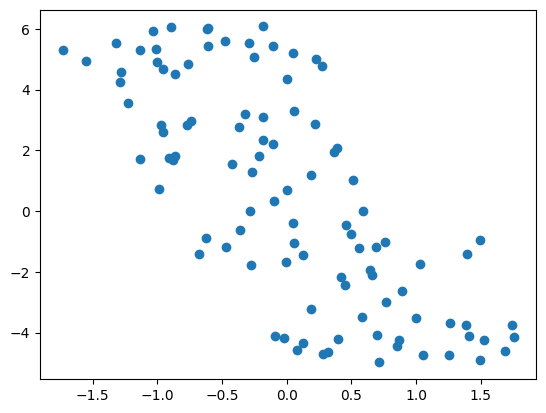

In [59]:
    # prompt: plot data
    import matplotlib.pyplot as plt

    plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
    plt.show()

In [60]:
    %%time
    # # Set parameters and run the Ant Cluster Algorithm
    n_ants = 10
    n_clusters = 4
    ant_cluster = AntCluster(n_ants, n_clusters, data)
    best_solution, best_cost = ant_cluster.run()

100%|██████████| 100/100 [02:47<00:00,  1.68s/it]

CPU times: user 2min 44s, sys: 3.96 s, total: 2min 48s
Wall time: 2min 47s


In [61]:
    print("Best solution (cluster assignments):", best_solution)
    print("Best cost:", best_cost)

Best solution (cluster assignments): [3 3 3 3 3 3 3 3 3 3 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 3 2 2 2 2 2 2 2 0 0 0 0 0 1 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1]
Best cost: 125.97534236634603


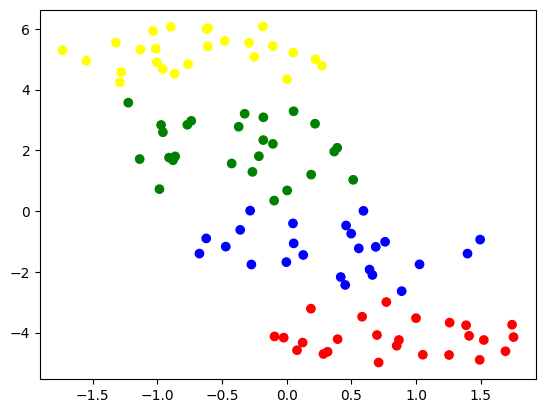

In [62]:
    # prompt: plot data with best_solution in mind where best_solution returns a list of indices that separate the data by 2 classes. Give each class a different color.

    colors = []
    for i in range(len(data)):
        if best_solution[i] == 1:
            colors.append('red')
        elif best_solution[i] == 2:
            colors.append('green')
        elif best_solution[i] == 3:
            colors.append('yellow')
        elif best_solution[i] == 0:
            colors.append('blue')
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=colors)
    plt.show()

In [24]:
import pandas as pd

df = pd.read_csv('autos.csv')

feat_cols = [ 'f'+str(i) for i in range(df.shape[1]) ]
df.columns = feat_cols

In [25]:
df.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24
0,3,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9,111,5000,21,27,13495
1,3,alfa-romero,gas,std,2,convertible,rwd,front,88.6,168.8,...,130,mpfi,3.47,2.68,9,111,5000,21,27,16500
2,1,alfa-romero,gas,std,2,hatchback,rwd,front,94.5,171.2,...,152,mpfi,2.68,3.47,9,154,5000,19,26,16500
3,2,audi,gas,std,4,sedan,fwd,front,99.8,176.6,...,109,mpfi,3.19,3.40,10,102,5500,24,30,13950
4,2,audi,gas,std,4,sedan,4wd,front,99.4,176.6,...,136,mpfi,3.19,3.40,8,115,5500,18,22,17450


In [26]:
for column in df.columns:
  if df[column].dtype == 'object':
    print(len(df[column].unique()))

21
2
2
5
3
2
5
7


In [27]:
def transform(df, column):
  d = {}
  i = 0
  for u in df[column].unique():
    d[u] = i
    i += 1
  for k, v in d.items():
    df.loc[df[column] == k, column] = v
  return df.drop(column, axis=1)

In [28]:
for column in df.columns:
  if df[column].dtype == 'object':
    transform(df, column)

In [29]:
df.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24
0,3,0,0,0,2,0,0,0,88.6,168.8,...,130,0,3.47,2.68,9,111,5000,21,27,13495
1,3,0,0,0,2,0,0,0,88.6,168.8,...,130,0,3.47,2.68,9,111,5000,21,27,16500
2,1,0,0,0,2,1,0,0,94.5,171.2,...,152,0,2.68,3.47,9,154,5000,19,26,16500
3,2,1,0,0,4,2,1,0,99.8,176.6,...,109,0,3.19,3.40,10,102,5500,24,30,13950
4,2,1,0,0,4,2,2,0,99.4,176.6,...,136,0,3.19,3.40,8,115,5500,18,22,17450


In [30]:
df.tail()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24
188,-1,20,0,0,4,2,0,0,109.1,188.8,...,141,0,3.78,3.15,9,114,5400,23,28,16845
189,-1,20,0,1,4,2,0,0,109.1,188.8,...,141,0,3.78,3.15,8,160,5300,19,25,19045
190,-1,20,0,0,4,2,0,0,109.1,188.8,...,173,0,3.58,2.87,8,134,5500,18,23,21485
191,-1,20,1,1,4,2,0,0,109.1,188.8,...,145,5,3.01,3.40,23,106,4800,26,27,22470
192,-1,20,0,1,4,2,0,0,109.1,188.8,...,141,0,3.78,3.15,9,114,5400,19,25,22625


In [31]:
df.shape

(193, 25)

In [32]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(df)

In [33]:
scaled_df.shape

(193, 25)

In [34]:
scaled_df.dtype

dtype('float64')

In [35]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1000)
tsne_results = tsne.fit_transform(scaled_df)
tsne_results.shape

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 193 samples in 0.001s...
[t-SNE] Computed neighbors for 193 samples in 0.018s...
[t-SNE] Computed conditional probabilities for sample 193 / 193
[t-SNE] Mean sigma: 0.610032
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.010334
[t-SNE] KL divergence after 1000 iterations: 0.217248


(193, 2)

In [36]:
tsne_results

array([[-6.74651098e+00, -3.53698778e+00],
       [-6.73953485e+00, -3.53045559e+00],
       [-6.65770626e+00, -2.32530022e+00],
       [ 3.29992676e+00,  2.91457510e+00],
       [ 7.93737888e+00,  1.28181982e+00],
       [-7.99913502e+00, -2.17566872e+00],
       [ 7.56698608e+00,  4.49676365e-01],
       [ 7.57230473e+00,  4.19322550e-01],
       [ 8.64897728e+00,  4.15516831e-02],
       [-7.66501474e+00, -2.24234343e+00],
       [ 3.63638544e+00,  8.87635887e-01],
       [-6.57493639e+00, -2.13632965e+00],
       [ 3.86777925e+00, -1.69168904e-01],
       [ 3.93693137e+00, -5.07913947e-01],
       [ 3.91791415e+00, -1.56604064e+00],
       [-4.29074860e+00, -1.91170621e+00],
       [ 3.87554264e+00, -2.15393615e+00],
       [-1.28995333e+01, -3.19232416e+00],
       [-1.17293377e+01, -2.89101815e+00],
       [ 2.68498063e+00,  6.07708645e+00],
       [-1.14882631e+01, -2.86221433e+00],
       [-1.09394054e+01, -2.82935166e+00],
       [-5.53935099e+00,  2.95307422e+00],
       [ 3.

In [40]:
transformed_tnse = pd.DataFrame(tsne_results)
transformed_tnse.T

,0,1,2,3,4,5,6,7,8,9,...,183,184,185,186,187,188,189,190,191,192
0,-6.746511,-6.739535,-6.657706,3.299927,7.937379,-7.999135,7.566986,7.572305,8.648977,-7.665015,...,6.583668,6.267024,6.555268,1.479871,1.449224,6.264912,1.490379,5.642758,2.266405,1.519988
1,-3.536988,-3.530456,-2.325300,2.914575,1.281820,-2.175669,0.449676,0.419323,0.041552,-2.242343,...,-2.483565,-2.696748,-2.491782,-1.940675,-1.828706,-2.298378,-1.819404,-2.136914,-7.958447,-1.851066


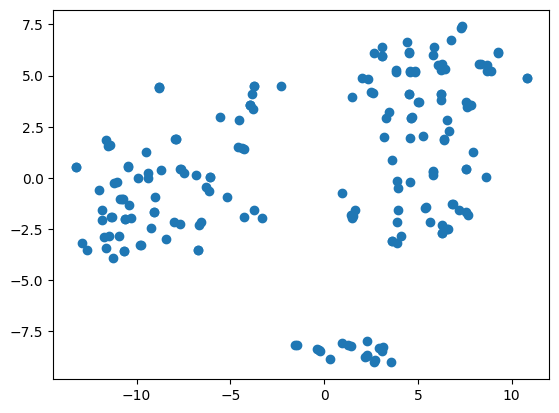

In [15]:
# prompt: plot data
import matplotlib.pyplot as plt

plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
plt.show()

In [42]:
%%time
# # Set parameters and run the Ant Cluster Algorithm
n_ants = 10
n_clusters = 3
ant_cluster = AntCluster(n_ants, n_clusters, tsne_results)
best_solution, best_cost = ant_cluster.run()

100%|██████████| 3/3 [00:04<00:00,  1.46s/it]

CPU times: total: 3.81 s
Wall time: 4.4 s


In [43]:
print("Best solution (cluster assignments):", best_solution)
print("Best cost:", best_cost)

Best solution (cluster assignments): [1 1 1 2 2 1 2 2 0 1 2 1 2 0 0 0 0 1 1 2 1 1 1 2 2 0 2 1 0 1 1 1 1 2 2 1 1
 2 2 2 1 2 1 0 0 1 1 1 1 0 2 1 2 1 2 2 0 0 0 0 2 0 0 1 0 0 1 1 1 1 1 2 1 0
 1 1 2 2 0 0 1 2 1 1 0 1 1 2 2 1 2 2 2 2 2 1 1 1 0 0 0 0 0 0 0 0 0 1 0 1 1
 2 2 2 2 2 1 1 1 1 0 2 1 2 0 0 1 1 1 2 2 1 2 0 2 0 2 2 2 1 2 2 2 2 0 2 0 0
 2 2 2 1 1 1 2 1 1 1 1 1 1 2 2 2 2 2 1 1 0 0 1 1 1 2 2 0 2 1 1 2 0 0 0 0 0
 0 0 0 0 0 0 0 0]
Best cost: 824.0332808196545


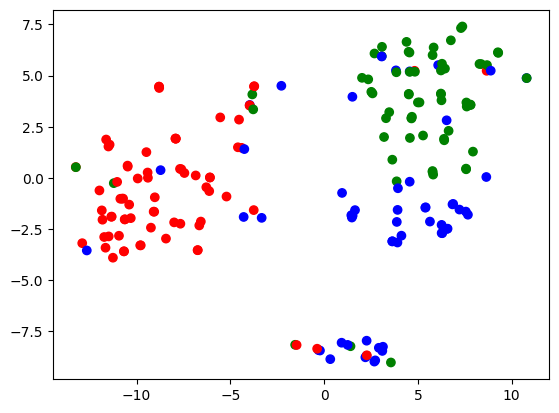

In [44]:
# prompt: plot data with best_solution in mind where best_solution returns a list of indices that separate the data by 2 classes. Give each class a different color.

colors = []
for i in range(len(scaled_df)):
    if best_solution[i] == 1:
        colors.append('red')
    elif best_solution[i] == 2:
        colors.append('green')
    elif best_solution[i] == 3:
        colors.append('yellow')
    elif best_solution[i] == 0:
        colors.append('blue')
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=colors)
plt.show()

In [45]:
transformed_tnse['colors'] = colors
transformed_tnse

,0,1,colors
0,-6.746511,-3.536988,red
1,-6.739535,-3.530456,red
2,-6.657706,-2.325300,red
3,3.299927,2.914575,green
4,7.937379,1.281820,green
...,...,...,...
188,6.264912,-2.298378,blue
189,1.490379,-1.819404,blue
190,5.642758,-2.136914,blue
191,2.266405,-7.958447,blue


In [46]:
transformed_tnse.T

,0,1,2,3,4,5,6,7,8,9,...,183,184,185,186,187,188,189,190,191,192
0,-6.746511,-6.739535,-6.657706,3.299927,7.937379,-7.999135,7.566986,7.572305,8.648977,-7.665015,...,6.583668,6.267024,6.555268,1.479871,1.449224,6.264912,1.490379,5.642758,2.266405,1.519988
1,-3.536988,-3.530456,-2.3253,2.914575,1.28182,-2.175669,0.449676,0.419323,0.041552,-2.242343,...,-2.483565,-2.696748,-2.491782,-1.940675,-1.828706,-2.298378,-1.819404,-2.136914,-7.958447,-1.851066
colors,red,red,red,green,green,red,green,green,blue,red,...,blue,blue,blue,blue,blue,blue,blue,blue,blue,blue
